In [48]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pylab as plt
from datetime import datetime
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings('ignore')


In [7]:
data = pd.read_csv('NSE-Tata-Global-Beverages-Limited.csv')
data.sort_values(by='Date', ascending=True, inplace=True)
data = data.reset_index()
data.rename(columns={'Turnover (Lacs)': 'Turnover'}, inplace=True)
data['Price'] = (data['Turnover'] / data['Total Trade Quantity']) * 100000
data.head()

,index,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover,Price
0,1234,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94,156.296192
1,1233,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49,156.348618
2,1232,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80,159.329095
3,1231,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76,161.206694
4,1230,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09,159.127498


In [9]:
data = data[['Date', 'Price']]
data['Date']=pd.to_datetime(data['Date'])

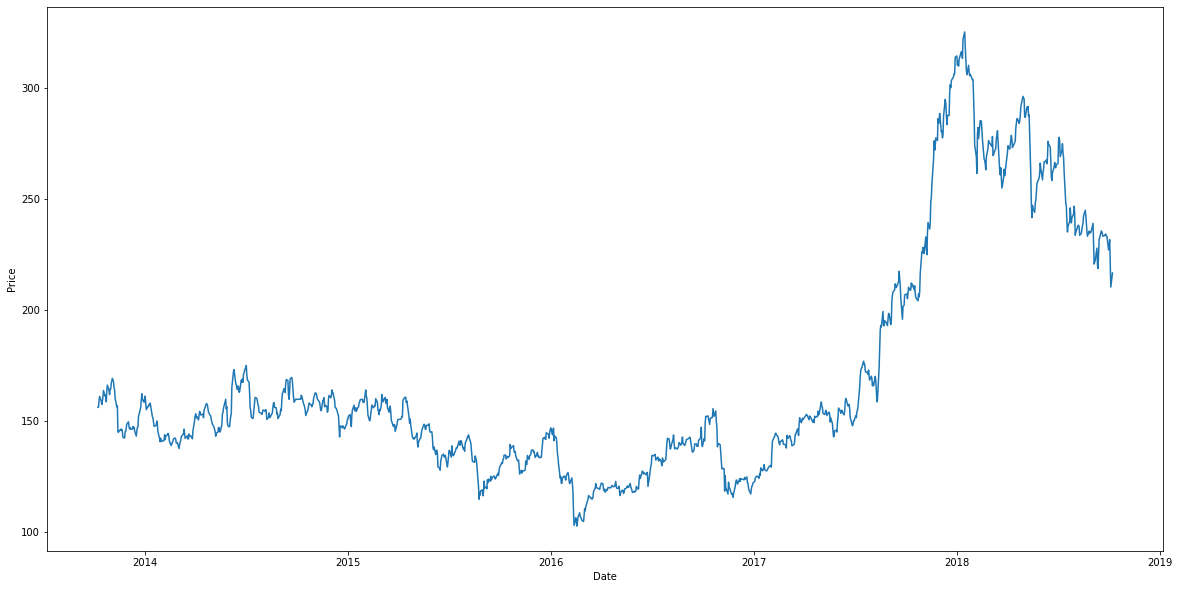

In [10]:
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(data['Date'], data['Price'])

In [33]:
def stationarity(timeseries):
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual = plt.plot(timeseries, color='red', label='Actual')
    mean = plt.plot(rolmean, color='green', label='Rolling Mean') 
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

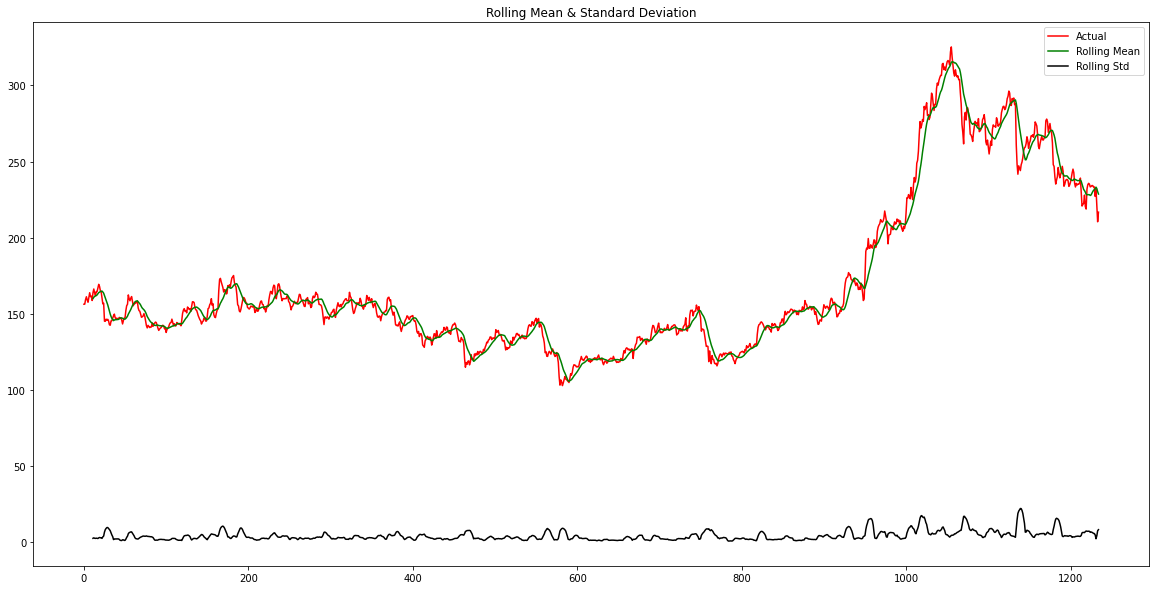

Dickey-Fuller Test: 
Test Statistic            -1.020903
p-value                    0.745564
Lags Used                  4.000000
No. of Obs              1230.000000
Critical Value (1%)       -3.435678
Critical Value (5%)       -2.863893
Critical Value (10%)      -2.568023
dtype: float64


In [35]:
stationarity(data['Price'])

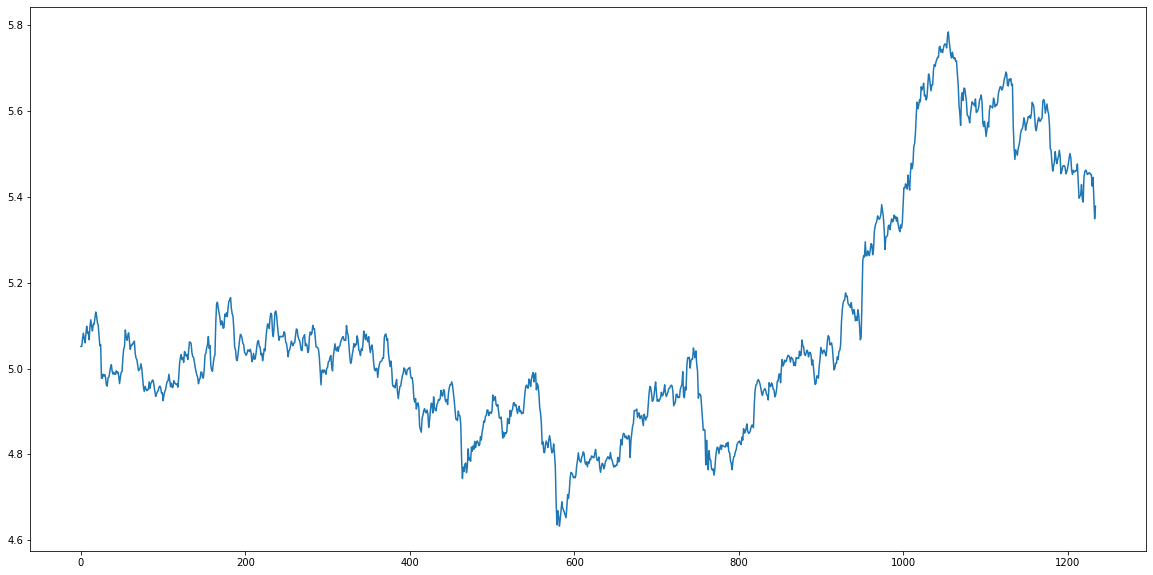

In [36]:
plt.figure(figsize=(20,10))
data_log=np.log(data['Price'])
plt.plot(data_log)

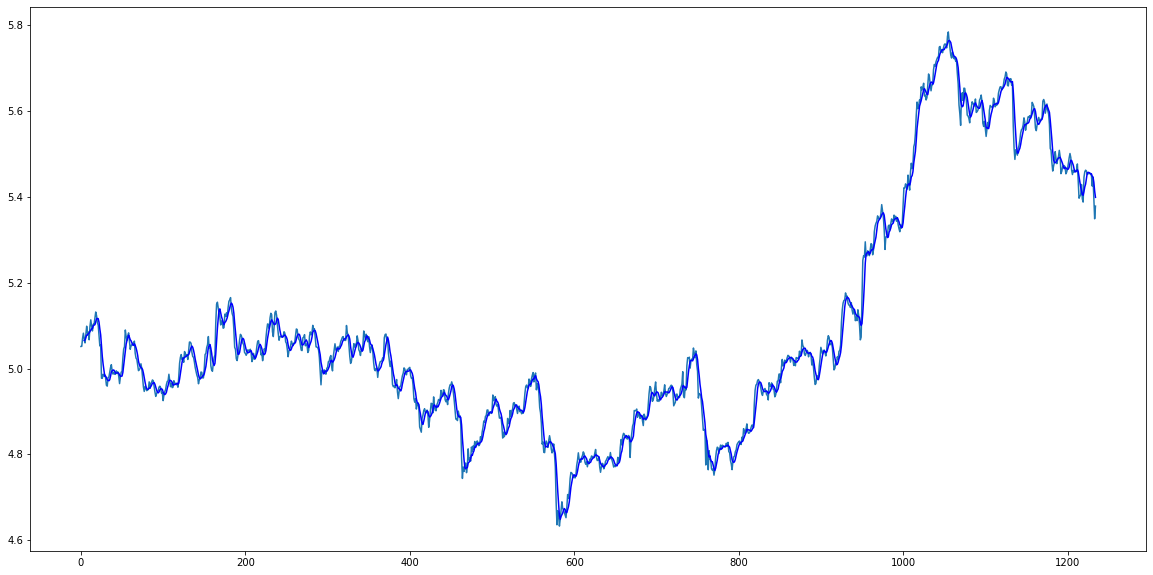

In [37]:
plt.figure(figsize=(20,10))
MAvg=data_log.rolling(window=5).mean()
MStd=data_log.rolling(window=5).std()
plt.plot(data_log)
plt.plot(MAvg, color='blue')

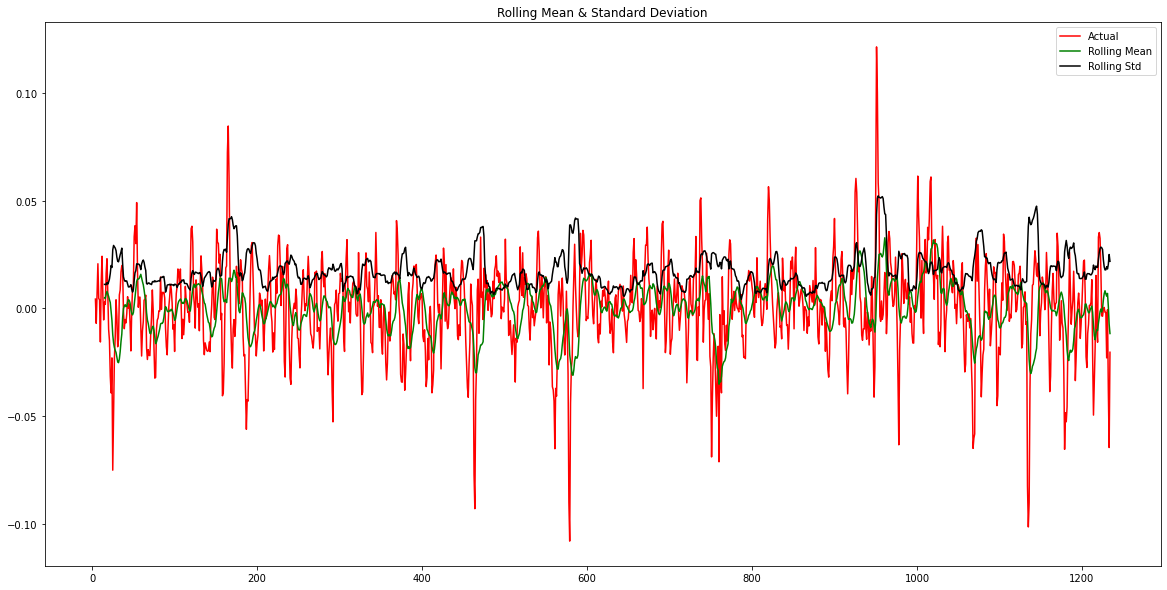

Dickey-Fuller Test: 
Test Statistic         -1.273059e+01
p-value                 9.394030e-24
Lags Used               5.000000e+00
No. of Obs              1.225000e+03
Critical Value (1%)    -3.435699e+00
Critical Value (5%)    -2.863902e+00
Critical Value (10%)   -2.568028e+00
dtype: float64


In [39]:
data_log_diff=data_log-MAvg
data_log_diff=data_log_diff.dropna()
stationarity(data_log_diff)

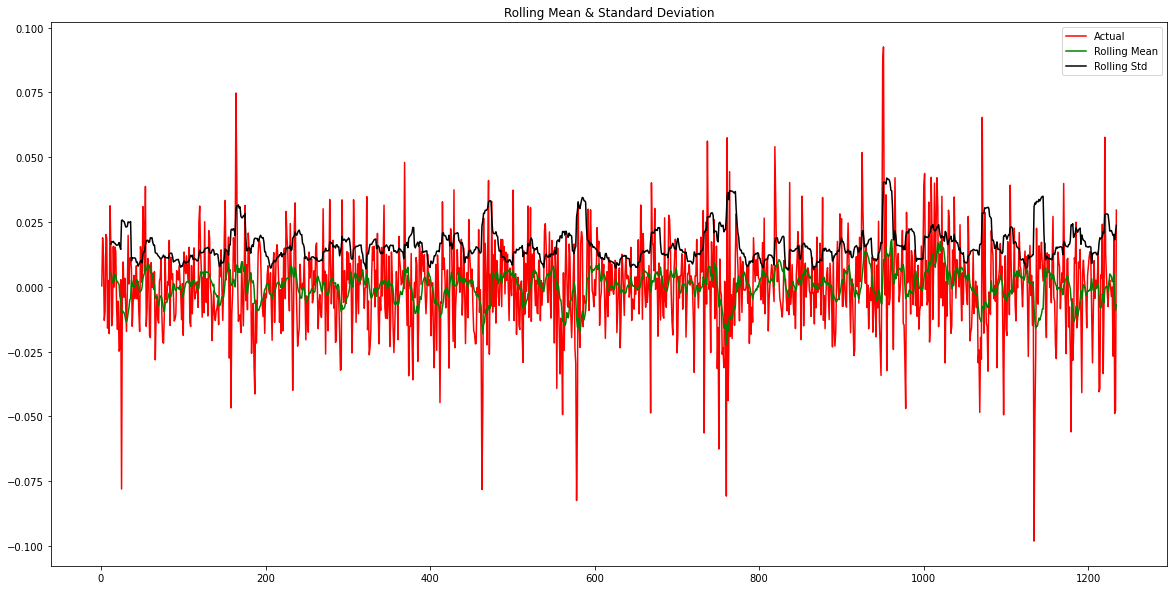

Dickey-Fuller Test: 
Test Statistic         -1.741680e+01
p-value                 4.851016e-30
Lags Used               3.000000e+00
No. of Obs              1.230000e+03
Critical Value (1%)    -3.435678e+00
Critical Value (5%)    -2.863893e+00
Critical Value (10%)   -2.568023e+00
dtype: float64


In [55]:
data_shift=data_log-data_log.shift()
data_shift.dropna(inplace=True)
stationarity(data_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

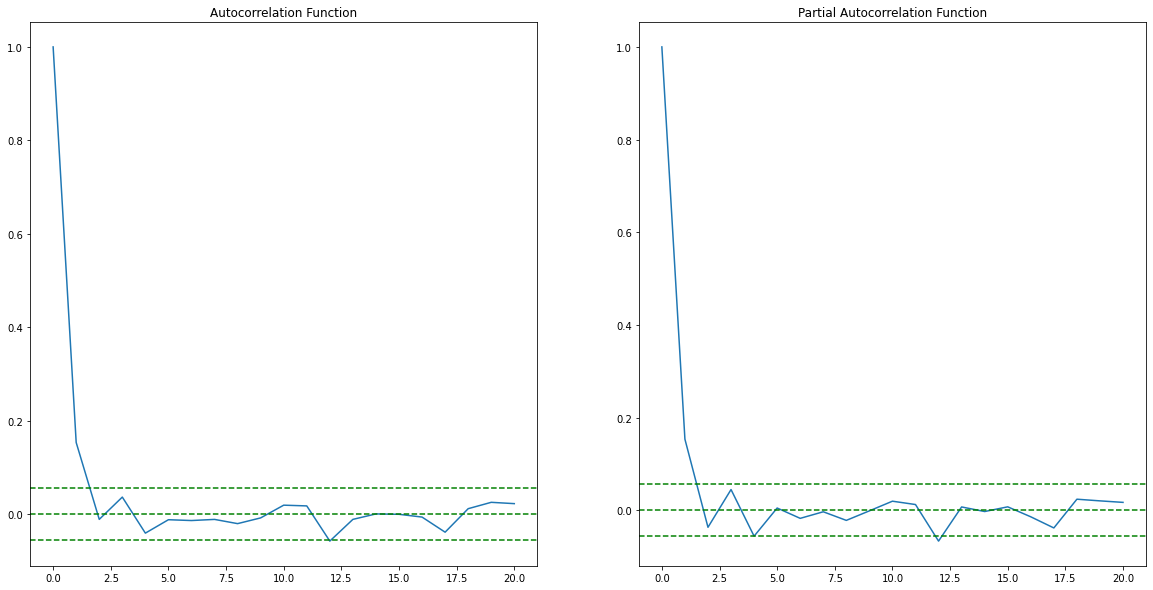

In [56]:
lag_acf=acf(data_shift, nlags=20)
lag_pacf=pacf(data_shift, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


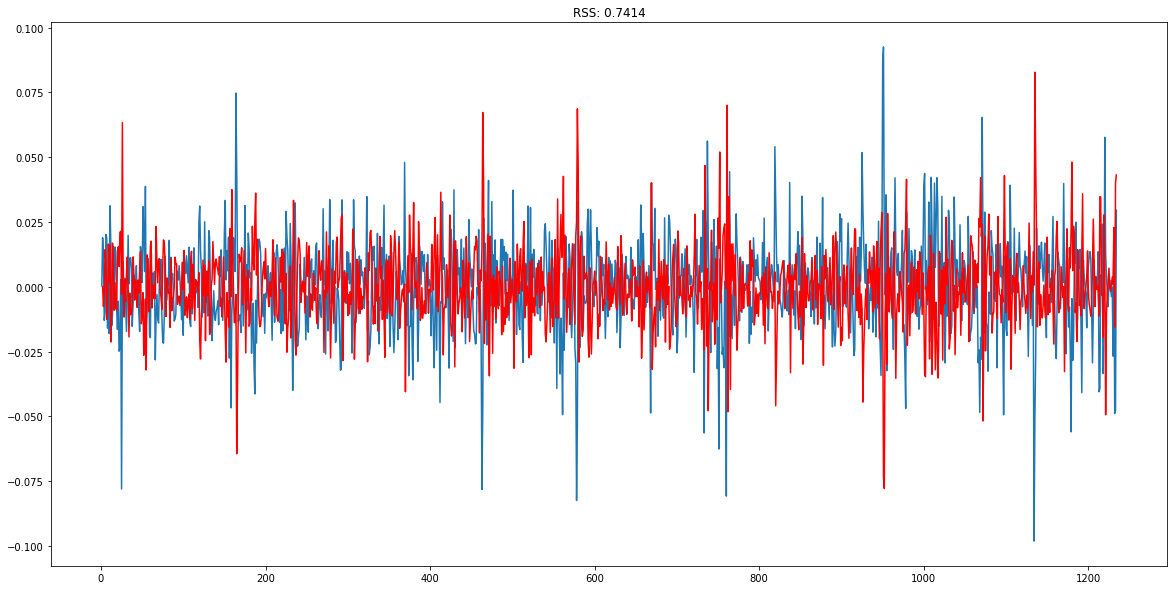

In [69]:
plt.figure(figsize=(20,10))
model=ARIMA(data_shift, order=(2,1,2))
results=model.fit(disp=-1)
plt.plot(data_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum(((results.fittedvalues-data_shift)[1:])**2))
print('plotting ARIMA model')

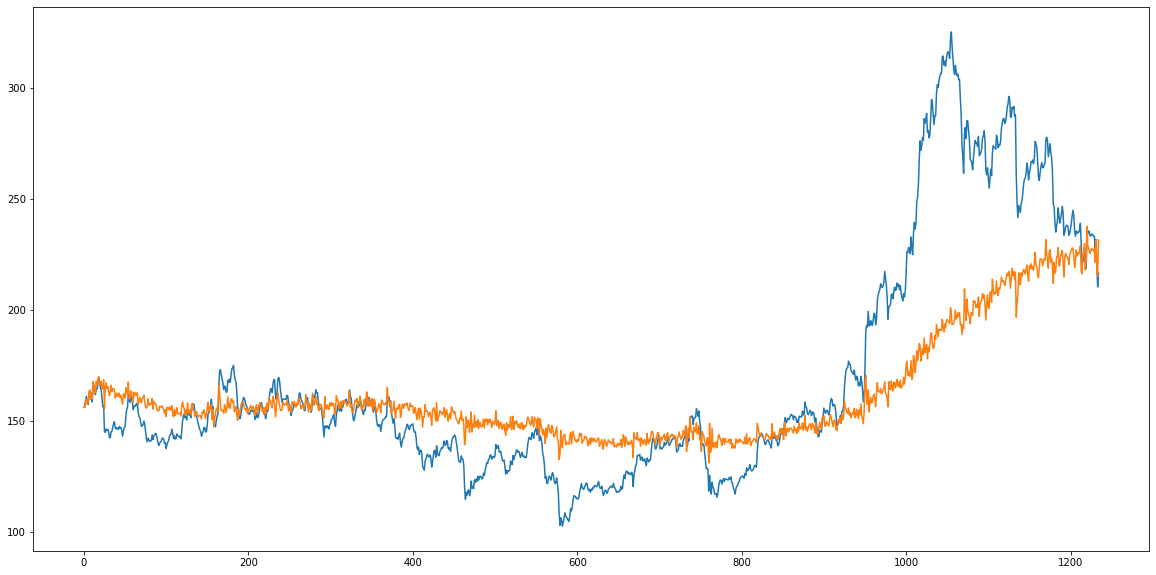

In [73]:
predictions=pd.Series(results.fittedvalues, copy=True)
predictions_cum_sum=predictions.cumsum()

predictions_log=data_log
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(20,10))
plt.plot(data['Price'])
plt.plot(predictions_ARIMA)

In [81]:
mse = sum((predictions_ARIMA-data['Price'])**2)/ data.shape[0]
print(f'MSE is {mse}')


MSE is 1090.4328066777614
